# Sarcasm Detection
 **Acknowledgement**

Misra, Rishabh, and Prahal Arora. "Sarcasm Detection using Hybrid Neural Network." arXiv preprint arXiv:1908.07414 (2019).

**Required Files given in below link.**

https://drive.google.com/drive/folders/1xUnF35naPGU63xwRDVGc-DkZ3M8V5mMk

## Install `Tensorflow2.0` 

In [1]:
!!pip uninstall tensorflow
!pip install tensorflow==2.0.0

  Using cached https://files.pythonhosted.org/packages/46/0f/7bd55361168bb32796b360ad15a25de6966c9c1beb58a8e30c01c8279862/tensorflow-2.0.0-cp36-cp36m-manylinux2010_x86_64.whl


## Get Required Files from Drive

In [2]:
from google.colab import drive
drive.mount('/content/drive/')

Drive already mounted at /content/drive/; to attempt to forcibly remount, call drive.mount("/content/drive/", force_remount=True).


In [3]:
#Set your project path 
project_path =  '/content/drive/My Drive/AIML/Colab_Notebook/Residency9/Project/Sarcasm_Detection/Data/'

In [4]:
import os
os.listdir(project_path)

['Sarcasm_Headlines_Dataset.json',
 'glove.6B.300d.txt',
 'glove.6B.zip',
 'glove.6B.100d.txt',
 'glove.6B.50d.txt',
 'glove.6B.200d.txt']

#**## Reading and Exploring Data**

## Read Data "Sarcasm_Headlines_Dataset.json". Explore the data and get  some insights about the data. ( 4 marks)
Hint - As its in json format you need to use pandas.read_json function. Give paraemeter lines = True.

In [5]:
import pandas as pd
import json
import matplotlib.pyplot as plt
import seaborn as sns
import re

/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


In [6]:
json_path = project_path + 'Sarcasm_Headlines_Dataset.json'
print(json_path)
scsm_df = pd.read_json(json_path,lines=True)

/content/drive/My Drive/AIML/Colab_Notebook/Residency9/Project/Sarcasm_Detection/Data/Sarcasm_Headlines_Dataset.json


In [7]:
scsm_df.head(5)

,article_link,headline,is_sarcastic
0,https://www.huffingtonpost.com/entry/versace-b...,former versace store clerk sues over secret 'b...,0
1,https://www.huffingtonpost.com/entry/roseanne-...,the 'roseanne' revival catches up to our thorn...,0
2,https://local.theonion.com/mom-starting-to-fea...,mom starting to fear son's web series closest ...,1
3,https://politics.theonion.com/boehner-just-wan...,"boehner just wants wife to listen, not come up...",1
4,https://www.huffingtonpost.com/entry/jk-rowlin...,j.k. rowling wishes snape happy birthday in th...,0


In [8]:
scsm_df.shape

(26709, 3)

In [9]:
scsm_df.isna().sum() 

article_link    0
headline        0
is_sarcastic    0
dtype: int64

In [10]:
from bs4 import BeautifulSoup
import nltk
nltk.download('stopwords')
from nltk.corpus import stopwords
import string 

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [11]:
stop = set(stopwords.words('english'))
punctuation = list(string.punctuation)
stop.update(punctuation)

In [12]:
def strip_html(text):
    soup = BeautifulSoup(text, "html.parser")
    return soup.get_text()

#Removing the square brackets
def remove_between_square_brackets(text):
    return re.sub('\[[^]]*\]', '', text)

# Removing URL's
def remove_between_square_brackets(text):
    return re.sub(r'http\S+', '', text)

#Removing the stopwords from text
def remove_stopwords(text):
    final_text = []
    for i in text.split():
        if i.strip().lower() not in stop:
            final_text.append(i.strip())
    return " ".join(final_text)

#Removing the noisy text
def denoise_text(text):
    text = strip_html(text)
    text = remove_between_square_brackets(text)
    text = remove_stopwords(text)
    return text



In [13]:
scsm_df['headline']=scsm_df['headline'].apply(denoise_text)

In [14]:
# scsm_df['headline'] = scsm_df['headline'].apply(lambda x: x.lower())
# scsm_df['headline'] = scsm_df['headline'].apply((lambda x: re.sub('[^a-zA-z0-9\s]','',x)))

Text(0.5, 1.0, 'Sarcasm vs Non-sarcasm')

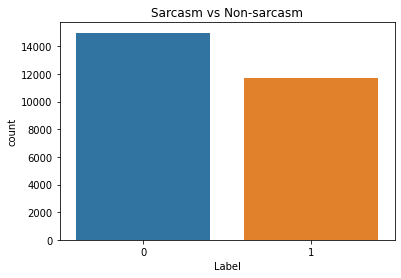

In [15]:
sns.countplot(scsm_df.is_sarcastic)
plt.xlabel('Label')
plt.title('Sarcasm vs Non-sarcasm')

## Drop `article_link` from dataset. ( 2 marks)
As we only need headline text data and is_sarcastic column for this project. We can drop artical link column here.

In [16]:
scsm_df=scsm_df.drop(['article_link'],axis=1) 
scsm_df.head(5)

,headline,is_sarcastic
0,former versace store clerk sues secret 'black ...,0
1,'roseanne' revival catches thorny political mo...,0
2,mom starting fear son's web series closest thi...,1
3,"boehner wants wife listen, come alternative de...",1
4,j.k. rowling wishes snape happy birthday magic...,0


## Get the Length of each line and find the maximum length. ( 4 marks)
As different lines are of different length. We need to pad the our sequences using the max length.

In [17]:
maxlen = scsm_df["headline"].str.len().max()
print(maxlen)

247


#**## Modelling**

## Import required modules required for modelling.

In [18]:
import numpy as np
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.layers import Dense, Input, LSTM, Embedding, Dropout, Activation, Flatten, Bidirectional, GlobalMaxPool1D
from tensorflow.keras.models import Model, Sequential

# Set Different Parameters for the model. ( 2 marks)

In [19]:
max_features = 10000
#maxlen = ## Defined above ##
embedding_size = 200

## Apply Keras Tokenizer of headline column of your data.  ( 4 marks)
Hint - First create a tokenizer instance using Tokenizer(num_words=max_features) 
And then fit this tokenizer instance on your data column df['headline'] using .fit_on_texts()

In [20]:
tokenizer = Tokenizer(num_words=max_features, split=' ')
tokenizer.fit_on_texts(scsm_df['headline'])

# Define X and y for your model.

In [21]:
X = tokenizer.texts_to_sequences(scsm_df['headline'])
X = pad_sequences(X, maxlen = maxlen)
y = np.asarray(scsm_df['is_sarcastic'])

print("Number of Samples:", len(X))
print(X[0])
print("Number of Labels: ", len(y))
print(y[0])

Number of Samples: 26709
[   0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0  

## Get the Vocabulary size ( 2 marks)
Hint : You can use tokenizer.word_index.

In [22]:
vocab_size=tokenizer.word_index
print(vocab_size)
print(len(vocab_size))

{'new': 1, 'trump': 2, 'man': 3, 'one': 4, 'report': 5, 'year': 6, 'area': 7, 'donald': 8, 'u': 9, 'day': 10, 'says': 11, 's': 12, 'first': 13, 'woman': 14, 'time': 15, 'like': 16, "trump's": 17, 'old': 18, 'get': 19, 'life': 20, 'people': 21, 'obama': 22, 'house': 23, 'still': 24, "'": 25, 'women': 26, 'make': 27, 'white': 28, 'back': 29, 'clinton': 30, '5': 31, 'world': 32, 'could': 33, 'americans': 34, 'way': 35, 'family': 36, 'gop': 37, 'study': 38, 'school': 39, 'black': 40, 'best': 41, 'years': 42, 'bill': 43, '3': 44, 'would': 45, 'police': 46, 'watch': 47, 'american': 48, 'really': 49, 'last': 50, 'know': 51, '10': 52, "can't": 53, 'death': 54, 'home': 55, 'video': 56, 'finds': 57, 'state': 58, 'president': 59, 'health': 60, 'going': 61, 'say': 62, 'show': 63, 'nation': 64, 'good': 65, 'things': 66, 'hillary': 67, "'the": 68, '2': 69, 'may': 70, 'campaign': 71, 'every': 72, 'love': 73, 'mom': 74, 'need': 75, 'big': 76, 'right': 77, 'party': 78, 'gets': 79, '000': 80, 'getting':

In [23]:
num_words = len(vocab_size) + 1

#**## Word Embedding**

## Get Glove Word Embeddings

In [24]:
glove_file = project_path + "glove.6B.zip"

In [25]:
#Extract Glove embedding zip file
from zipfile import ZipFile
with ZipFile(glove_file, 'r') as z:
  z.extractall()

# Get the Word Embeddings using Embedding file as given below.

In [26]:
EMBEDDING_FILE = project_path + 'glove.6B.200d.txt'

embeddings = {}
for o in open(EMBEDDING_FILE):
    word = o.split(" ")[0]
    # print(word)
    embd = o.split(" ")[1:]
    embd = np.asarray(embd, dtype='float32')
    # print(embd)
    embeddings[word] = embd



In [27]:
print(EMBEDDING_FILE)

/content/drive/My Drive/AIML/Colab_Notebook/Residency9/Project/Sarcasm_Detection/Data/glove.6B.200d.txt


# Create a weight matrix for words in training docs

In [28]:
embedding_matrix = np.zeros((num_words, 200))

for word, i in tokenizer.word_index.items():
    embedding_vector = embeddings.get(word)
    if embedding_vector is not None:
        embedding_matrix[i] = embedding_vector

len(embeddings.values())

400000

## Create and Compile your Model  ( 7 marks)
Hint - Use Sequential model instance and then add Embedding layer, Bidirectional(LSTM) layer, then dense and dropout layers as required. 
In the end add a final dense layer with sigmoid activation for binary classification.


In [29]:
### Embedding layer for hint 
## model.add(Embedding(num_words, embedding_size, weights = [embedding_matrix]))
### Bidirectional LSTM layer for hint 
## model.add(Bidirectional(LSTM(128, return_sequences = True)))

In [30]:
model = Sequential()
#Non-trainable embeddidng layer
model.add(Embedding(num_words, embedding_size, weights = [embedding_matrix]))
#LSTM 
model.add(Bidirectional(LSTM(units=128 , return_sequences = True)))
#model.add(Flatten())  <--
model.add(Dense(1, activation='sigmoid'))
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['acc'])

In [31]:
del embedding_matrix

In [32]:
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding (Embedding)        (None, None, 200)         5918000   
_________________________________________________________________
bidirectional (Bidirectional (None, None, 256)         336896    
_________________________________________________________________
dense (Dense)                (None, None, 1)           257       
Total params: 6,255,153
Trainable params: 6,255,153
Non-trainable params: 0
_________________________________________________________________


# Fit your model with a batch size of 100 and validation_split = 0.2. and state the validation accuracy ( 5 marks)


In [33]:
batch_size = 100
epochs = 5

## Add your code here ##

In [34]:
history = model.fit(X, y, epochs=epochs, batch_size=batch_size,validation_split=0.2, verbose=1)

Train on 21367 samples, validate on 5342 samples
Epoch 1/5
21367/21367 [==============================] - 536s 25ms/sample - loss: 0.6738 - acc: 0.5870 - val_loss: 0.6795 - val_acc: 0.5731
Epoch 2/5
21367/21367 [==============================] - 533s 25ms/sample - loss: 0.6663 - acc: 0.5922 - val_loss: 0.6209 - val_acc: 0.6691
Epoch 3/5
21367/21367 [==============================] - 535s 25ms/sample - loss: 0.5900 - acc: 0.6993 - val_loss: 0.6796 - val_acc: 0.5739
Epoch 4/5
21367/21367 [==============================] - 533s 25ms/sample - loss: 0.6773 - acc: 0.5683 - val_loss: 0.6778 - val_acc: 0.5760
Epoch 5/5
21367/21367 [==============================] - 530s 25ms/sample - loss: 0.6529 - acc: 0.5701 - val_loss: 0.6474 - val_acc: 0.5745
